<a href="https://colab.research.google.com/github/All4Nothing/pytorch-DL-project/blob/main/Ch03_Deep_CNN_Architecture(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. 심층 CNN 아키텍처

## GoogLeNet과 Inception v3 살펴보기

 GoogLeNet은 inception 모듈이라고 하는 병렬 합성곱 계층의 모듈로 구성된 근본적으로 다른 유형의 CNN 아키텍처로 등장했다.  
 이 때문에 GoogLeNet은 **Inception v1**이라고 한다  
 *  **Inception 모듈** - 여러 병렬 합성곱 계층으로 구성된 모듈
 *  모델 매개변수 개수를 줄이기 위해 **1x1 합성곱**을 사용
 *  완전 연결 계층 대신 **전역 평균 풀링**을 사용해 과적합을 줄임
 *  훈련 시 정칙화 및 경사 안정성을 위해 **보조 분류기**(auxiliary classifier)를 사용

### Inception 모듈  
이 모델의 가장 중요한 공헌은, 여러 합성곱 계층이 병렬로 실행되어 최종적으로 단일 출력 벡터를 생성하기 위해 연결되는 합성곱 모듈을 개발했다는 것이다.  
이 병렬 합성곱 계층은 1x1, 3x3, 5x5에 이르기까지 다양한 크기의 커널을 사용해 동작한다.  
아이디어는 이미지에서 여러 층위의 시각 정보를 추출하는 것이다.  
이 합성곱 외에 3x3 최대 풀링 계층은 다른 층위의 특징 추출을 더한다.  
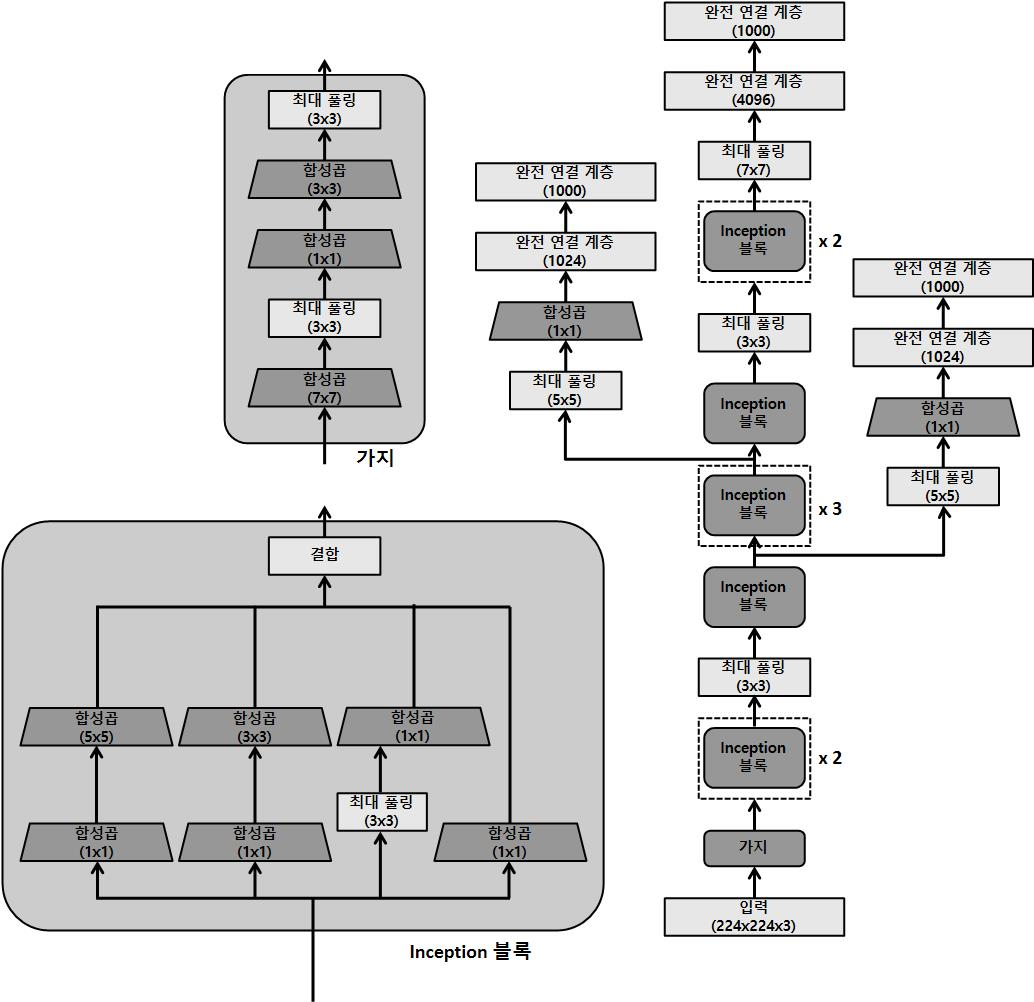

In [2]:
import torch.nn as nn

In [3]:
class InceptionModule(nn.Module):
  def __init(
      self,
      input_planes,
      n_channels1x1,
      n_channels3x3red,
      n_channels3x3,
      n_channels5x5red,
      n_channels5x5,
      pooling_planes
  ):
      super(InceptionModule, self).__init__()
      # 1x1 convolution branch(합성곱 가지)
      self.block1 = nn.Sequential(
          nn.Conv2d(input_planes, n_channels1x1, kernel_size=1),
          nn.ReLU(True),
      )

      # 1x1 convolution -> 3x3 convolution branch
      self.block2 = nn.Sequential(
          nn.Conv2d(input_planes, n_channels3x3red, kernel_size=1),
          nn.BatchNorm2d(n_channels3x3red),
          nn.ReLU(True),
          nn.Conv2d(n_channels3x3red, n_channels3x3, kernel_size=3, padding=1),
          nn.BatchNorm2d(n_channels3x3),
          nn.ReLU(True),
      )

      # 1x1 conv -> 5x5 conv branch
      self.block3 = nn.Sequential(
          nn.Conv2d(input_planes, n_channels5x5red, kernel_size=1),
          nn.BatchNorm2d(n_channels5x5red),
          nn.ReLU(True),
          nn.Conv2d(n_channels5x5red, n_channels5x5, kernel_size=3, padding=1),
          nn.BatchNorm2d(n_channels5x5),
          nn.ReLU(True),
          nn.Conv2d(n_channels5x5, n_channels5x5, kernel_size=3, padding=1),
          nn.ReLU(True),
      )

      # 3x3 pool -> 1x1 conv branch
      self.block4 = nn.Sequential(
          nn.MaxPool2d(3, stride=1, padding=1),
          nn.Conv2d(input_planes, pooling_planes, kernel_size=1),
          nn.BatchNorm2d(pooling_planes),
          nn.ReLU(True),
      )

  def forward(self, ip):
    op1 = self.block1(ip)
    op2 = self.block2(ip)
    op3 = self.block3(ip)
    op4 = self.block4(ip)
    return torch.cat([op1,op2,op3,op4], 1)

### 1x1 합성곱  
Inception 모듈의 병렬 합성곱 계층 외에 각 병렬 계층의 맨 앞에는 **1x1 합성곱 계층**이 있다. 이 1x1 합성곱 계층을 사용하는 이유는 차원 축소에 있다. 1x1 합성곱 계층은 이미지 표현의 넓이와 높이를 변경하지 않지만 이미지 표현의 깊이를 바꿀 수 있다. 이 기법은 1x1, 3x3, 5x5 합성곱을 병렬로 수행하기 전에 입력 시각 특징의 깊이를 축소하는데 사용된다. 매개변수 개수를 줄이면 모델이 가벼워질뿐 아니라 과적합을 피할 수 있다.
*   일반적으로 행과 열의 사이즈를 줄이고 싶다면 Pooling을 사용하면 된다.
*   그렇다면 채널의 수를 줄이고 싶다면 1x1 convolution을 사용한다.  
*   예를 들어 (28 x 28 x 192)의 input을 (28 x 28 x 32)로 줄이려면, (1 x 1 x 192) 필터를 32개 사용하여 convolution 연산을 하는 것이다.

### 전역 평균 풀링  
전반적인 GoogLeNet 아키텍처를 보면, 모델 끝에서 두 번째 출력 계층 앞에 7x7 평균 풀링 계층이 있다.  
이 계층은 다시 모델의 매개변수 개수를 줄이는 데 도움이 되어 과적합을 줄인다.  
이 계층이 없으면 모델은 완전 연결 계층의 조밀한 연결로 인해 수백만 개의 추가 매개변수를 갖게 된다.

### 보조 분류기  
보조 분류기는 특히 입력에 가까운 계층인 경우, 역전파하는 동안 경사의 크기를 더함으로써 경사가 소실되는 문제를 해결해준다.  
이러한 모델에는 계층이 많아서 경사가 소실되면 병목 현상이 발생할 수 있다.  
따라서 보조 분류기를 사용하는 것이 이 22개 계층을 갖는 심층 모델에 유용한 것으로 입증됐다.  
또한 보조 분류기는 정규화(regularization)에도 도움이 된다. 예측하는 동안에는 이 보조 분기가 꺼지거나 폐기된다.

In [4]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.im1 = InceptionModule(192,  64,  96, 128, 16, 32, 32)
        self.im2 = InceptionModule(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.im3 = InceptionModule(480, 192,  96, 208, 16,  48,  64)
        self.im4 = InceptionModule(512, 160, 112, 224, 24,  64,  64)
        self.im5 = InceptionModule(512, 128, 128, 256, 24,  64,  64)
        self.im6 = InceptionModule(512, 112, 144, 288, 32,  64,  64)
        self.im7 = InceptionModule(528, 256, 160, 320, 32, 128, 128)

        self.im8 = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.im9 = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.average_pool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(4096, 1000)

    def forward(self, ip):
        op = self.stem(ip)
        out = self.im1(op)
        out = self.im2(op)
        op = self.maxpool(op)
        op = self.a4(op)
        op = self.b4(op)
        op = self.c4(op)
        op = self.d4(op)
        op = self.e4(op)
        op = self.max_pool(op)
        op = self.a5(op)
        op = self.b5(op)
        op = self.avgerage_pool(op)
        op = op.view(op.size(0), -1)
        op = self.fc(op)
        return op

In [5]:
# 모델 인스턴스화 하는 것 외에도 코드 두 줄로 사전 훈련된 GoogLeNet을 로딩할 수 있다.
import torchvision.models as models
model = models.googlenet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 251MB/s]


## Inception v3  
Inception v3는 Inception v1의 후속 모델로, 매개변수의 증가, 계층 수 증가 외에도 이 모델은 순차적으로 쌓인 다양한 종류의 inception 모듈을 도입했다.

In [6]:
import torchvision.models as models
model = models.inception_v3(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 277MB/s] 
